In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')

import string
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Initialize an empty list to store the records
records = []

# file_path=
# Open and read the text file
with open(r'/content/drive/My Drive/Colab Notebooks/foods.txt', 'r', encoding='latin1') as file:
    record = {}  # Initialize an empty dictionary for each record
    for line in file:
        line = line.strip()
        if not line:  # Check for empty line to separate records
            if record:  # Append the record dictionary to the list
                records.append(record)
            record = {}  # Initialize a new record
        elif ':' in line:  # Check if the line contains a colon
            key, value = line.split(': ', 1)  # Split each line into key and value
            record[key] = value

# Append the last record (if it exists) since the file may not end with an empty line
if record:
    records.append(record)

# Create a DataFrame from the list of records
df = pd.DataFrame(records)

# Show the DataFrame
df

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0/0,5.0,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0/0,2.0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1/1,5.0,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
#columns are renamed
df.columns=['productid','userid','name','helpfulness','score','time','summary','review']
df['HFN'] = df['helpfulness'].apply(lambda x: int(x.split('/')[0]))
df['HFD'] = df['helpfulness'].apply(lambda x: int(x.split('/')[1]))


In [ ]:
df.isna().sum()

productid      0
userid         0
name           0
helpfulness    0
score          0
time           0
summary        0
review         0
HFN            0
HFD            0
dtype: int64

In [ ]:
df.duplicated().sum()

281

In [ ]:
df = df.drop_duplicates(subset=['productid','userid','time','review'],keep='first',inplace=False)

In [ ]:
def preprocessing(text):
    # Define stopwords
    stop_words = set(stopwords.words("english"))

    # Function to remove stopwords
    def remove_stopwords(sentence):
        return ' '.join([w for w in sentence.split() if not w in stop_words])

    # Clean text
    def clean_text(sentence):
        sentence = sentence.lower()
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        sentence = ' '.join(sentence.split())
        return sentence

    # Stemming
    stemmer = SnowballStemmer("english")
    def stemming(sentence):
        return ' '.join([stemmer.stem(word) for word in sentence.split()])

    # Lemmatization
    # lemmatizer = WordNetLemmatizer()
    # def lemmatization(sentence):
    #     return ' '.join([lemmatizer.lemmatize(word) for word in sentence.split()])

    # Remove URLs
    text = re.sub(r"http\S+", "", text)

    # Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()

    # Apply functions
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemming(text)
    # Uncomment the following line if you want to use lemmatization
    # text = lemmatization(text)

    return text

In [ ]:
# Apply preprocessing functions
df['review'] = df['review'].apply(preprocessing)

<ipython-input-10-7c7e3d6afe9b>:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()
<ipython-input-11-aaa1b1017793>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].apply(preprocessing)


In [ ]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df['compound_score'] = df['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

def sentiment_types(compound_score):
    if compound_score > 0.1:
        return 'Positive'
    elif compound_score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound_score'].apply(sentiment_types)

df.head()

<ipython-input-12-cb395e36f5a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound_score'] = df['review'].apply(lambda x: sia.polarity_scores(x)['compound'])
<ipython-input-12-cb395e36f5a3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['compound_score'].apply(sentiment_types)


,productid,userid,name,helpfulness,score,time,summary,review,HFN,HFD,compound_score,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,bought sever vital can dog food product found ...,1,1,0.9081,Positive
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,product arriv label jumbo salt peanut peanut a...,0,0,-0.1027,Negative
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",confect around centuri light pillowi citrus ge...,1,1,0.6249,Positive
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,look secret ingredi robitussin believ found go...,3,3,0.4404,Positive
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,great taffi great price wide assort yummi taff...,0,0,0.9186,Positive


**Visualization**

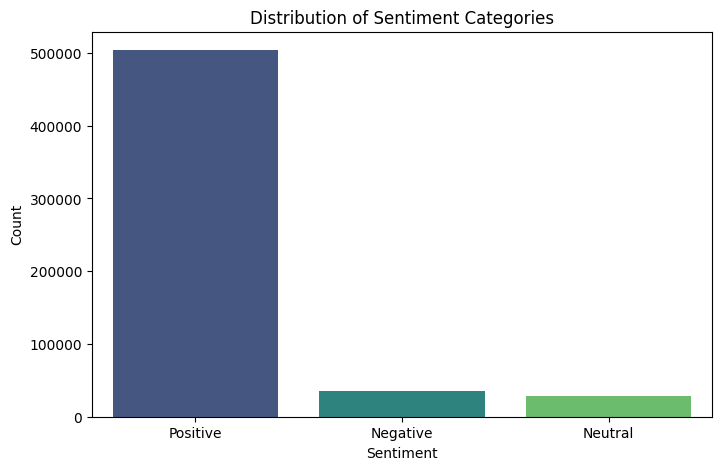

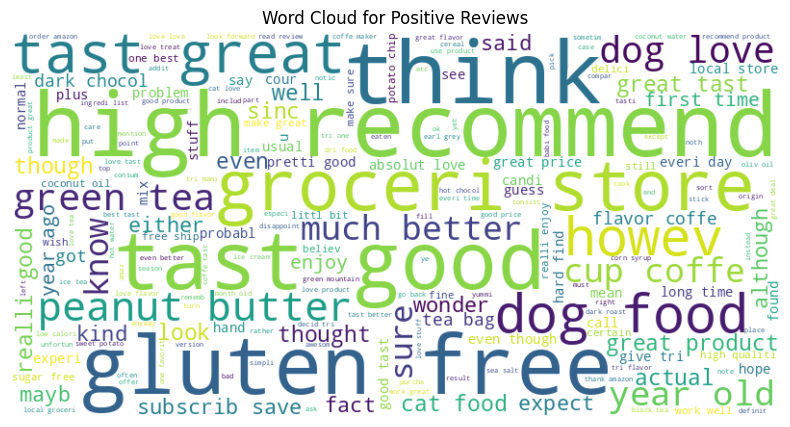

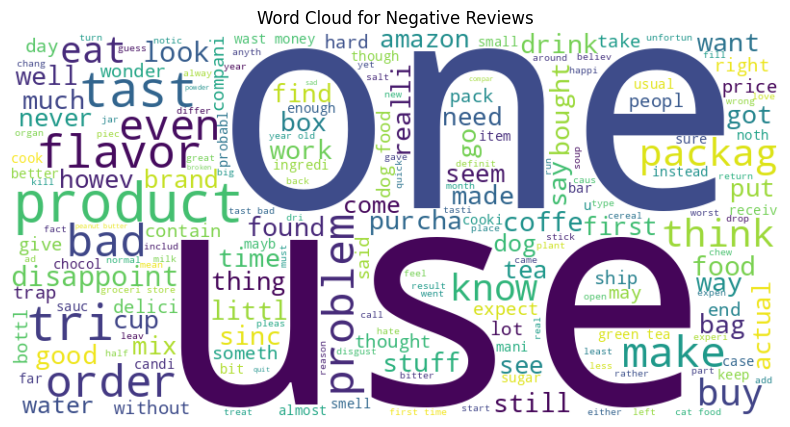

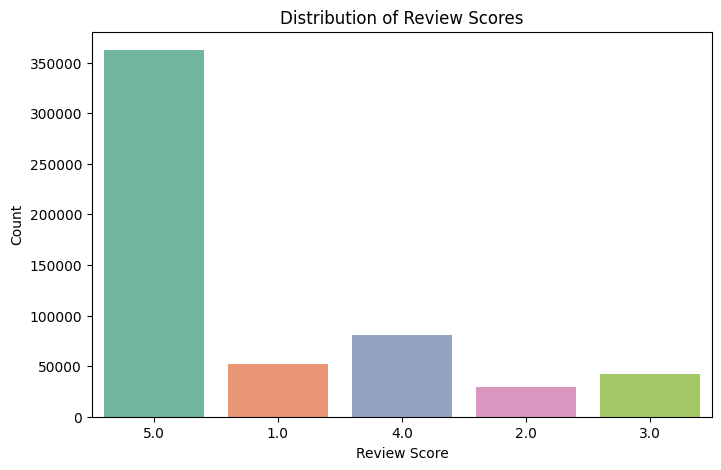

<ipython-input-14-a5d5601bdf37>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_length'] = df['review'].apply(len)
<ipython-input-14-a5d5601bdf37>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'], unit='s')


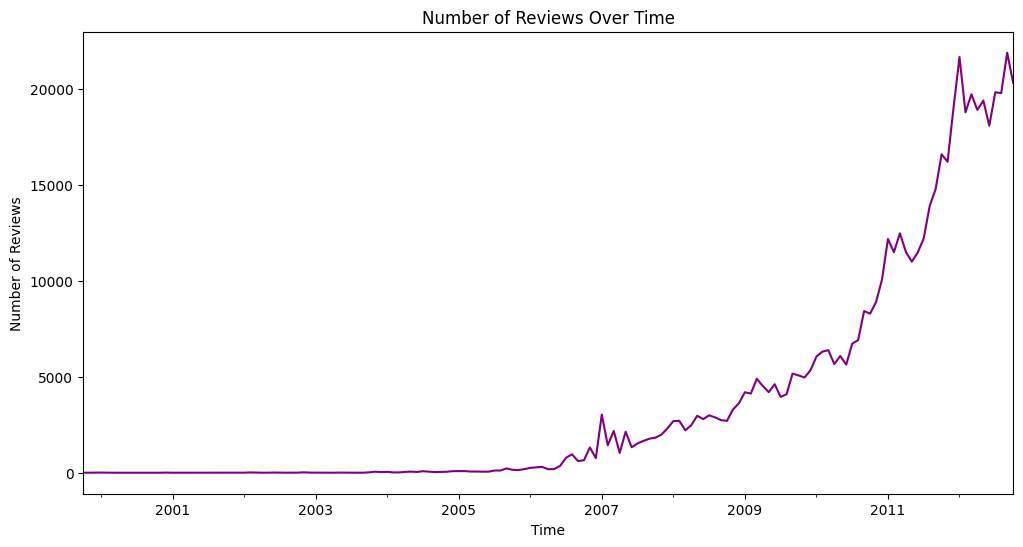

In [ ]:
# Bar plot for the distribution of sentiment categories
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()



# Word cloud for positive reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'Positive']['review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word cloud for negative reviews
negative_reviews = ' '.join(df[df['sentiment'] == 'Negative']['review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

# Bar plot for the distribution of review scores
plt.figure(figsize=(8, 5))
sns.countplot(x='score', data=df, palette='Set2')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()


# Bar plot for the distribution of review lengths
df['review_length'] = df['review'].apply(len)

# Time series plot for the number of reviews over time
df['time'] = pd.to_datetime(df['time'], unit='s')
df_time_series = df.resample('M', on='time').size()

plt.figure(figsize=(12, 6))
df_time_series.plot(color='purple')
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# Creating a copy of the dataframe
df_ = df.copy()

# Convert 'score' column to numeric, handling errors by coercing to NaN
df_['score'] = pd.to_numeric(df_['score'], errors='coerce')

# Drop rows where 'score' is NaN
df_ = df_.dropna(subset=['score'])

# Convert 'score' column to int
df_['score'] = df_['score'].astype(int)

# Get the total number of rows in the original DataFrame
total_rows = df_.shape[0]

# Remove rows where score == 3
df_ = df_.loc[df_['score'] != 3]

# Get the number of rows removed
rows_removed = total_rows - df_.shape[0]

print(f"No. of rows removed: {rows_removed}")

# Create the 'Sentiment' column
df_['Sentiment'] = np.where(df_['score'] > 3, 1, 0)


No. of rows removed: 42558


<ipython-input-21-9c6ce8e57137>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['Sentiment'] = np.where(df_['score'] > 3, 1, 0)


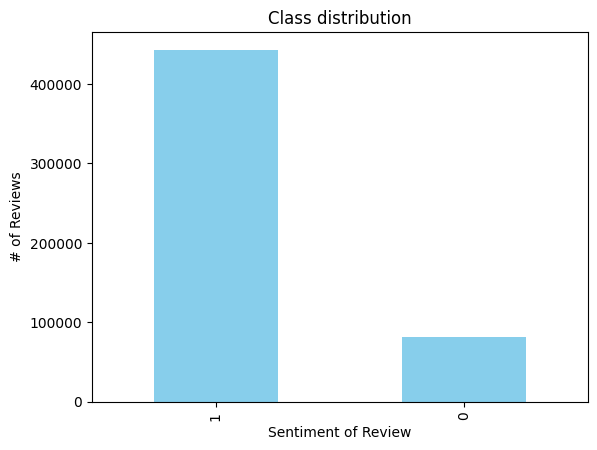

In [ ]:
# Class distribution
fig = df_.Sentiment.value_counts().plot.bar(color='skyblue')
fig.set_title("Class distribution")
fig.set_ylabel("# of Reviews")
fig.set_xlabel("Sentiment of Review")
plt.show()

##Down Sampling

In [ ]:
#negative reviews
neg_data = df_.loc[df_.Sentiment == 0]

# positive reviews
pos_data = df_.loc[df_.Sentiment == 1][:neg_data.shape[0]]

# balanced df_
a = df_.shape[0]
df_ = pd.concat([pos_data, neg_data])
df_ = df_.sample(frac=1, random_state=1)
b = df_.shape[0]


print("No. of rows removed :", a-b)

print(f"\nPercentage of df_ removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of df_ remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 361245

Percentage of df_ removed: 63.68%
Percentage of df_ remaining: 28.81%


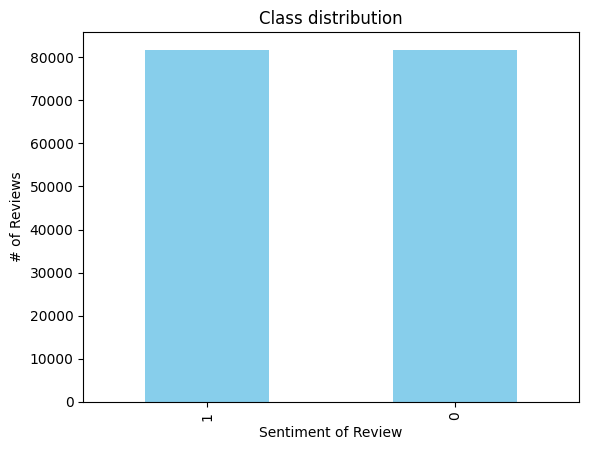

In [ ]:
# Class distribution
fig = df_.Sentiment.value_counts().plot.bar(color='skyblue')
fig.set_title("Class distribution")
fig.set_ylabel("# of Reviews")
fig.set_xlabel("Sentiment of Review")
plt.show()

In [ ]:
# UTILITY FUNCTIONS

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, cbar=False, cmap='viridis', annot=True, fmt='.0f')
    plt.title("Confusion matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    return plt.show()

# Accuracy Scorer
def get_accuracy_score(model,X_train, y_train, X_test, y_test, return_model=False):
    model = model.fit(X_train, y_train)
    y_preds_train = model.predict(X_train)
    y_preds = model.predict(X_test)
    print("Train accuracy:", accuracy_score(y_train, y_preds_train))
    print("Test accuracy:", accuracy_score(y_test, y_preds))
    print()
    return model if return_model==True else None

In [ ]:
X=df_['review']
y=df_['Sentiment']

In [ ]:
# Data splitting :train - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Tfidf-vectorizer
vectorizer = TfidfVectorizer(max_features=15000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=15000)

In [ ]:
tfidf_X_train = vectorizer.transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)

In [ ]:
#Multinomial Naive Bayes
get_accuracy_score(MultinomialNB(),tfidf_X_train, y_train, tfidf_X_test, y_test)

Train accuracy: 0.8768925797820271
Test accuracy: 0.8632225539621164



In [ ]:
#Logistic regression
get_accuracy_score(LogisticRegression(),tfidf_X_train, y_train, tfidf_X_test, y_test)

Train accuracy: 0.9051670691117927
Test accuracy: 0.8920268219861974



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##Hyper parameter tuning

In [ ]:
search = GridSearchCV(cv=None,
                      estimator=LogisticRegression(),
                      param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
                      scoring='accuracy',
                      n_jobs=-1)
search.fit(tfidf_X_train, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [ ]:
print(search.best_score_)

0.8944886933619196


In [ ]:
print(search.best_estimator_)

LogisticRegression(C=10)


In [ ]:
# Training final model
final_model = get_accuracy_score(search.best_estimator_,
                           tfidf_X_train, y_train,
                           tfidf_X_test, y_test,
                           return_model=True)

Train accuracy: 0.9181703974417542
Test accuracy: 0.8933483432039547



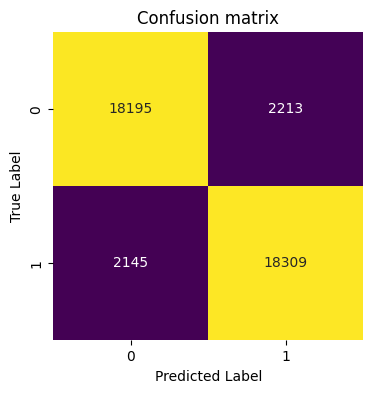

In [ ]:
#Confusion matrix
y_pred = final_model.predict(tfidf_X_test)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [ ]:
def create_target(x):
    return "Positive" if x > 3 else "Negative" if x < 3 else "Neutral"

# Convert 'score' column to numeric values
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# Assuming 'score' is the column name for the scores
df['target'] = df['score'].apply(create_target)

# Display the updated DataFrame
print(df)

         productid          userid                             name  \
0       B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1       B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2       B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3       B000UA0QIQ  A395BORC6FGVXV                             Karl   
4       B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...            ...             ...                              ...   
568449  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

       helpfulness  score       time                             summary  \
0              1/1    5.0 2011-04-27               Good Quality Dog Foo

In [ ]:
X = df.review
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((114046,), (28512,))

In [ ]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [ ]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()


In [ ]:
###
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

**Logistic Regression with BoW**

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.650456833207653
Test accuracy score : 0.645131874298541

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.6543587675148624
Test accuracy score : 0.6436938832772167

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.668624940813356
Test accuracy score : 0.6331018518518519

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.6781474142012872
Test accuracy score : 0.6169332210998878

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.6789190326710275
Test accuracy score : 0.6113566217732884

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
filename = f'logistic_regression_bow_model_c_{c}.pickle'
with open(filename, 'wb') as file:
  pickle.dump(log_model, file)

print(f"Model with C={c} saved to {filename}")

Model with C=10 saved to logistic_regression_bow_model_c_10.pickle


**Naive Bayes Classifier with BoW**

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



MultinomialNB(alpha=0)
Train accuracy score : 0.7220156778843625
Test accuracy score : 0.6959525813692481

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7207179559125265
Test accuracy score : 0.6971450617283951

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7196832856917385
Test accuracy score : 0.6968294051627385

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7191133402311348
Test accuracy score : 0.6965137485970819

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.718569699945636
Test accuracy score : 0.6961630190796857

 ----------------------------------------


In [ ]:
    # Save the model to a pickle file
    filename = f'naive_bayes_bow_model_alpha_{a}.pickle'
    with open(filename, 'wb') as file:
        pickle.dump(nb_model, file)

    print(f"Model with alpha={a} saved to {filename}")

Model with alpha=1 saved to naive_bayes_bow_model_alpha_1.pickle


**Logistic Regression with Tf-Idf**

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6138926398120057
Test accuracy score : 0.6133557800224467

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.700726022832892
Test accuracy score : 0.6950757575757576

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7473563299019694
Test accuracy score : 0.7295524691358025

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7856478964628308
Test accuracy score : 0.7477553310886644

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.8119355347842099
Test accuracy score : 0.7470538720538721

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Save the model to a pickle file
filename = 'logistic_regression_tfidf_model.pickle'
with open(filename, 'wb') as file:
    pickle.dump(log_model, file)

print(f"Model saved to {filename}")

Model saved to logistic_regression_tfidf_model.pickle


**Naive Bayes classifier with Tf-Idf**

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



MultinomialNB(alpha=0)
Train accuracy score : 0.7310646581204076
Test accuracy score : 0.6985830527497194

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7292232958630728
Test accuracy score : 0.7006874298540965

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7273293232555285
Test accuracy score : 0.7015993265993266

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7268295249285376
Test accuracy score : 0.702020202020202

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7262946530347404
Test accuracy score : 0.702300785634119

 ----------------------------------------


In [ ]:
    # Save the model to a pickle file
    filename = f'naive_bayes_tfidf_model_alpha_{a}.pickle'
    with open(filename, 'wb') as file:
        pickle.dump(nb_model, file)

    print(f"Model with alpha={a} saved to {filename}")

Model with alpha=1 saved to naive_bayes_tfidf_model_alpha_1.pickle


**Model Evaluation**

In [ ]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)

    return plt.show()

In [ ]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [ ]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [ ]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.7856478964628308
Test accuracy score : 0.7477553310886644
